In [1]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [2]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import seaborn as sns
import math
from tqdm.notebook import tqdm
import random
from typing import List, Tuple


@dataclass
class Args:
    random_seed = None
    # torch
    batch_size = 10
    epochs = 100
    layers = 10
    layer_size = 16
    train_size = 0.8
    wandb = False
    # graph
    graph_size = 600
    graph_shape = 'disc'
    rg_radius = 0.08

args = Args()

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


In [4]:
NodePosition = Tuple[float, float]
NodePositions = List[NodePosition]
NodeIndexPairs = List[Tuple[int, int]]

def gen_nodes(size: int, shape: str = "disc") -> NodePositions:
    if shape == 'disc':
        return __gen_nodes_disc(size)
    else:
        raise f'unsupported node shape: {shape}'


def __gen_nodes_disc(amount: int) -> NodePositions:
    points = []
    with tqdm(total=amount, desc="generating random-uniform nodes on disc") as pbar:
        while len(points) < amount:
            p = (random.uniform(0, 1), random.uniform(0, 1))
            d = (p[0] - 0.5, p[1] - 0.5)
            if math.sqrt(d[0] * d[0] + d[1] * d[1]) > 0.5:
                continue
            points.append(p)
            pbar.update(1)
    return points


def get_node_pairs(n_nodes: int) -> NodeIndexPairs:
    return [
        (i0, i1)
        for i0 in tqdm(range(n_nodes), desc="generating node pairs")
        for i1 in range(i0 + 1, n_nodes)
    ]


# https://stackoverflow.com/a/36460020/10619052
def list_to_dict(items: list) -> dict:
    return {v: k for v, k in enumerate(tqdm(items, desc="creating dict from list"))}

In [5]:
# Define graph builder
class RandomGeometricGraphBuilder:
    def __init__(self):
        # generate graph
        self.nodes = gen_nodes(args.graph_size, args.graph_shape)
        self.n_nodes = len(self.nodes)
        self.graph = nx.random_geometric_graph(
            self.n_nodes,
            args.rg_radius,
            pos=list_to_dict(self.nodes)
        )
        self.node_index_pairs = get_node_pairs(self.n_nodes)
        self.edges: NodeIndexPairs = [
            (i0, i1)
            for (i0, i1) in tqdm(self.node_index_pairs, desc="generating dataset labels from node pairs")
            if self.graph.has_edge(i0, i1)
        ]

In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.linear_relu_stack = nn.Sequential(
        #    nn.Linear(4, args.layer_size),
        #    nn.ReLU(),
        #    nn.Linear(args.layer_size, args.layer_size),
        #    nn.ReLU(),
        #    nn.Linear(args.layer_size, 2)
        #)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [7]:
# Define evaluator
class EmbeddingEvaluator:
    def __init__(self, nodes: NodePositions, edges: NodeIndexPairs, embedding: NodePositions):
        self.nodes = nodes # used for 2D representation of graph (not used in training)
        self.n_nodes = len(nodes)
        self.node_index_pairs = get_node_pairs(self.n_nodes)
        self.edges = edges
        self.embedding = embedding
        # generate net
        self.net = None
        self.reset_net()
        # generate dataset
        self.ds_values = torch.FloatTensor([
            [*self.embedding[i0], *self.embedding[i1]] # type: [float, float, float, float]
            for (i0, i1) in tqdm(self.node_index_pairs, desc="generating dataset values from node pairs")
        ]).to(device)
        self.ds_labels = torch.FloatTensor([
            1 if (edge in self.edges) else 0
            for edge in tqdm(self.node_index_pairs, desc="generating dataset labels from node pairs")
        ]).to(device)
        self.dataset = TensorDataset(self.ds_values, self.ds_labels)
        #? do we ant to over-fit?
        self.train_dataset, self.test_dataset = torch.utils.data.random_split(self.dataset, [args.train_size, 1 - args.train_size])
        # use custom sampler that keeps labels in balance
        labels_unique, labels_count = np.unique(self.ds_labels.cpu(), return_counts=True) # independent of train-test split (has both classes)
        labels_weights = [
            (1 / labels_count[int(l)])
            for _, l in self.train_dataset
        ]
        self.train_sampler = WeightedRandomSampler(labels_weights, len(self.train_dataset), replacement=True)

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=args.batch_size, sampler=self.train_sampler)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=args.batch_size)


    def reset_net(self):
        self.net = NeuralNetwork().to(device)


    def train(self, loss_fn, optimizer):
        self.net.train()
        with tqdm(total=args.epochs, desc="training model...") as pbar:
            for epoch in range(args.epochs):
                pbar.set_description(f"epoch {epoch + 1}")
                epoch_loss = 0

                for i_batch, (x_train, y_train) in enumerate(self.train_dataloader):

                    optimizer.zero_grad()

                    y_pred = self.net(x_train)
                    loss = loss_fn(y_pred, y_train.unsqueeze(1))
                    # TODO calculate acc

                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                # update progress
                pbar.update(1)
                pbar.set_postfix_str(f"last epoch loss: {epoch_loss / len(self.train_dataloader):>6f}")


    def test(self):
        self.net.eval()
        all_pred_label = []
        all_label = []
        with torch.no_grad():
            for i_batch, (x_test, y_test) in enumerate(self.test_dataloader):
                y_pred = self.net(x_test)
                pred = torch.sigmoid(y_pred)
                pred_label = torch.round(pred)
                all_pred_label.append(pred_label.cpu().numpy())
                all_label.append(y_test.cpu().numpy())

        all_pred_label = sum([el.squeeze().tolist() for el in all_pred_label], [])
        all_label = sum([el.squeeze().tolist() for el in all_label], [])

        #confusion_matrix(all_label, all_pred_label)
        print(classification_report(all_label, all_pred_label))


    def evaluate(self, print_report: bool = True, print_graph: bool = True):
        self.net.eval()
        with torch.no_grad():
            out = self.net(self.ds_values.to(device))
            pred = torch.sigmoid(out)
            pred_label = torch.round(pred)

            if print_report:
                print(classification_report(
                    self.ds_labels.cpu().numpy(),
                    pred_label.cpu(),
                    labels=[0, 1]
                ))

            if print_graph:
                _pred = [el.squeeze().tolist() for el in pred]
                self.__print_graph(_pred)

            return out, pred, pred_label


    def __print_graph(self, pred: List[float]):
        fig, ax = plt.subplots(1, 2)
        nodes_dict = list_to_dict(self.nodes)

        # generate embedding graph
        embed_graph = nx.Graph()
        embed_graph.add_nodes_from(range(self.n_nodes))
        embed_graph.add_edges_from(self.edges)

        # print embed graph
        ax[0].set_axis_off()
        ax[0].set_aspect('equal')
        ax[0].set_title("original graph")
        nx.draw_networkx(embed_graph, pos=nodes_dict, ax=ax[0], node_size=5, with_labels=False, labels={})

        # generate predict graph
        colors_filtered = np.array([
            pred[i]
            for i, _ in enumerate(self.node_index_pairs)
            if pred[i] > 0.5
        ])
        colormap = sns.color_palette("flare", as_cmap=True)
        pred_graph = nx.Graph()
        pred_graph.add_nodes_from(range(self.n_nodes))
        pred_graph.add_edges_from([
            pair
            for i, pair in enumerate(self.node_index_pairs)
            if pred[i] > 0.5
        ])

        # print predicted graph
        ax[1].set_axis_off()
        ax[1].set_aspect('equal')
        ax[1].set_title("reconstructed graph")
        nx.draw_networkx(pred_graph, pos=nodes_dict, ax=ax[1], node_size=5, with_labels=False, labels={}, edge_color=colors_filtered, edge_cmap=colormap)

        # add color bar for predictions
        cax = fig.add_axes([ax[1].get_position().x1 + 0.01, ax[1].get_position().y0, 0.02, ax[1].get_position().height])
        fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap), cax=cax, label="confidence")

        plt.savefig('./filename.png', dpi=300)
        plt.show()

In [8]:
# build and run evaluator
graph_builder = RandomGeometricGraphBuilder()
evaluator = EmbeddingEvaluator(
    graph_builder.nodes,
    graph_builder.edges,
    graph_builder.nodes # for random geometric graph, the structure defines the embedding
)

evaluator.train(
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3)
)

generating random-uniform nodes on disc:   0%|          | 0/600 [00:00<?, ?it/s]

creating dict from list:   0%|          | 0/600 [00:00<?, ?it/s]

generating node pairs:   0%|          | 0/600 [00:00<?, ?it/s]

generating dataset labels from node pairs:   0%|          | 0/179700 [00:00<?, ?it/s]

generating node pairs:   0%|          | 0/600 [00:00<?, ?it/s]

generating dataset values from node pairs:   0%|          | 0/179700 [00:00<?, ?it/s]

generating dataset labels from node pairs:   0%|          | 0/179700 [00:00<?, ?it/s]

training model...:   0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
evaluator.test()

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     35104
         1.0       0.88      1.00      0.93       835

    accuracy                           1.00     35939
   macro avg       0.94      1.00      0.97     35939
weighted avg       1.00      1.00      1.00     35939



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175405
           1       0.89      1.00      0.94      4295

    accuracy                           1.00    179700
   macro avg       0.95      1.00      0.97    179700
weighted avg       1.00      1.00      1.00    179700



creating dict from list:   0%|          | 0/600 [00:00<?, ?it/s]

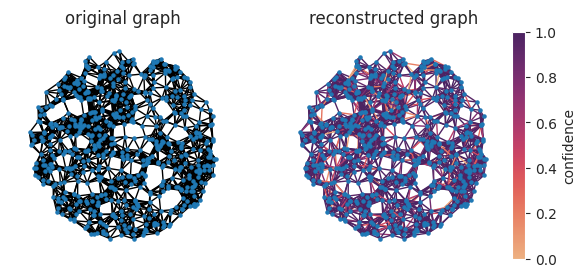

tensor([[0.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [7.7498e-36]], device='cuda:0')


In [10]:
# evaluate embedding
_, eval_pred, eval_pred_label = evaluator.evaluate()
print(eval_pred)